In [1]:
import pandas as pd

df = pd.read_parquet('../data/principal_components_with_labels.parquet')
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target
0,-2.998463,2.633157,0.032932,-1.602354,0.024525,-0.617761,0.036335,-0.417612,-0.065679,0.147202,...,-0.076582,0.039469,-0.027449,0.133269,-0.288124,-0.060768,0.042449,0.041903,-0.079951,happy
1,-2.492363,1.936940,-0.138884,-0.716433,0.349365,-0.329301,-0.057881,-0.352052,0.004583,0.147736,...,-0.166497,-0.101580,0.028404,0.034374,-0.167595,-0.112767,0.081890,0.051680,-0.036132,happy
2,-2.416042,2.062777,-0.090779,-0.774755,0.208401,-0.307223,-0.085082,-0.421737,0.065456,0.167330,...,-0.179506,-0.136642,0.001224,0.028825,-0.161050,-0.090177,0.097270,0.036769,-0.042106,happy
3,-2.387253,2.206515,-0.085263,-0.904430,0.126626,-0.336002,-0.103165,-0.480135,0.050860,0.161385,...,-0.174565,-0.161409,-0.022503,0.039457,-0.159132,-0.065670,0.079345,0.056077,-0.046078,happy
4,-2.859449,2.629995,0.072997,-0.804207,0.061594,-0.190146,-0.218555,-0.508417,0.052020,0.099988,...,-0.240840,-0.144809,-0.015104,0.178606,-0.122373,-0.087124,0.087087,0.033298,-0.089053,happy


In [2]:
import numpy as np

feature_cols = [col for col in df.columns if col.startswith('PC')]

def create_sliding_windows(data, label_col, window_size, step_size):
    sequences = []
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        sequences.append(window[feature_cols].values)
        label = window[label_col].mode()[0]
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 30
step_size = 8
X, y = create_sliding_windows(df, label_col='target', window_size=window_size, step_size=step_size)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

C:\Users\felip\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [5]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [6]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input

model = Sequential([
    Input(shape=(window_size, len(feature_cols))),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           76288     
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)])

Epoch 1/100
2730/2730 [==============================] - 50s 18ms/step - loss: 1.6843 - accuracy: 0.3114 - val_loss: 1.5841 - val_accuracy: 0.3663 - lr: 5.0000e-04
Epoch 2/100
2730/2730 [==============================] - 56s 20ms/step - loss: 1.5795 - accuracy: 0.3639 - val_loss: 1.5250 - val_accuracy: 0.3953 - lr: 5.0000e-04
Epoch 3/100
2730/2730 [==============================] - 58s 21ms/step - loss: 1.5272 - accuracy: 0.3931 - val_loss: 1.4861 - val_accuracy: 0.4168 - lr: 5.0000e-04
Epoch 4/100
2730/2730 [==============================] - 46s 17ms/step - loss: 1.4790 - accuracy: 0.4182 - val_loss: 1.4185 - val_accuracy: 0.4463 - lr: 5.0000e-04
Epoch 5/100
2730/2730 [==============================] - 47s 17ms/step - loss: 1.4278 - accuracy: 0.4474 - val_loss: 1.3728 - val_accuracy: 0.4723 - lr: 5.0000e-04
Epoch 6/100
2730/2730 [==============================] - 47s 17ms/step - loss: 1.3708 - accuracy: 0.4765 - val_loss: 1.3108 - val_accuracy: 0.4993 - lr: 5.0000e-04
Epoch 7/100
2730

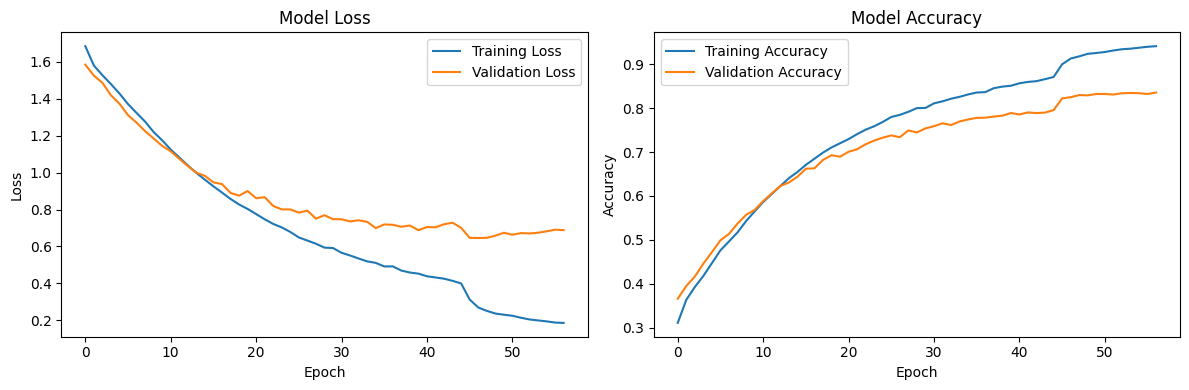

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

190/190 [==============================] - 2s 8ms/step - loss: 0.6798 - accuracy: 0.8167
Test Loss: 0.6798, Test Accuracy: 0.8167


190/190 [==============================] - 2s 7ms/step


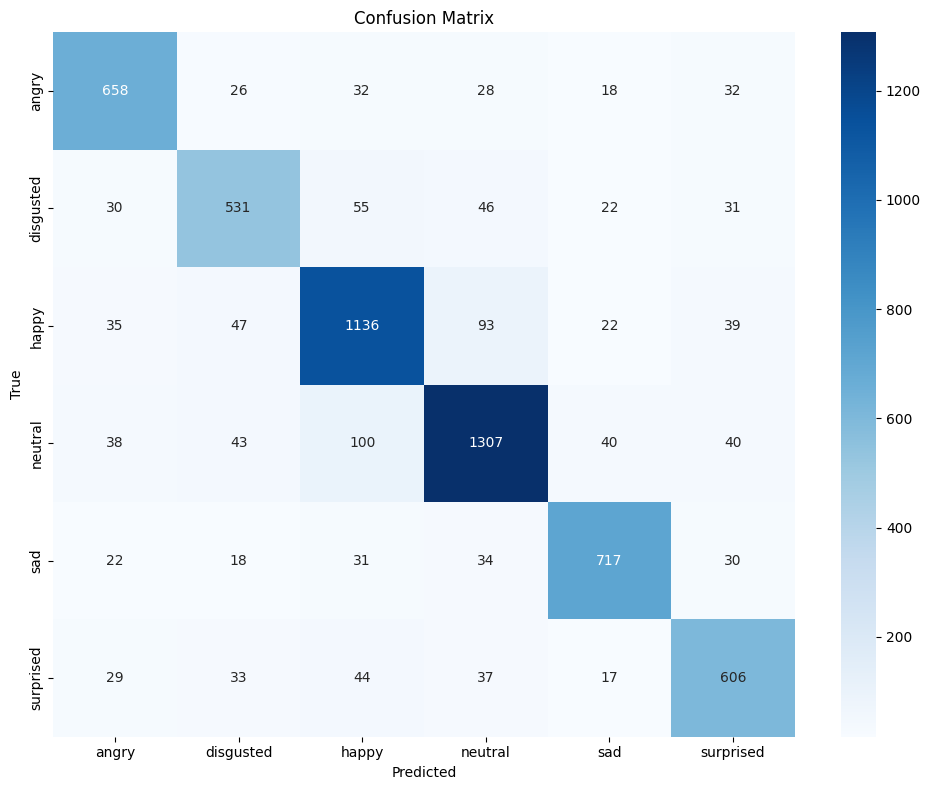

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

labels = ['angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [14]:
model.save('../models/facial_emotion_classifier.h5')